# 第4部　Box-Jenkins法とその周辺

## 第2章　ARIMAモデル

### 分析の準備

In [1]:
# 数値計算に使うライブラリ
import numpy as np
import pandas as pd

# グラフを描画するライブラリ
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

# 統計モデルを推定するライブラリ
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as tsa

# 再帰的に回帰分析を実行するための関数の読み込み
from sklearn.linear_model import LinearRegression
from sktime.forecasting.compose import make_reduction

# グラフの日本語表記
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'Meiryo'

In [2]:
# 表示設定
np.set_printoptions(linewidth=60)
pd.set_option('display.width', 80)

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 8, 4

### AR過程

#### AR過程に従うデータの例

In [3]:
# データの読み込み
ar_data = pd.read_csv(
    '4-2-1-ar-data.csv', index_col='date', parse_dates=True, dtype='float')

# 1日単位のデータ
ar_data.index.freq = 'D'

# 先頭行の確認
print(ar_data.head(3))

                posi      nega
date                          
2023-01-01  1.788628 -0.231497
2023-01-02  1.867413  0.680778
2023-01-03  1.590428 -1.115185


array([<Axes: xlabel='date'>, <Axes: xlabel='date'>],
      dtype=object)

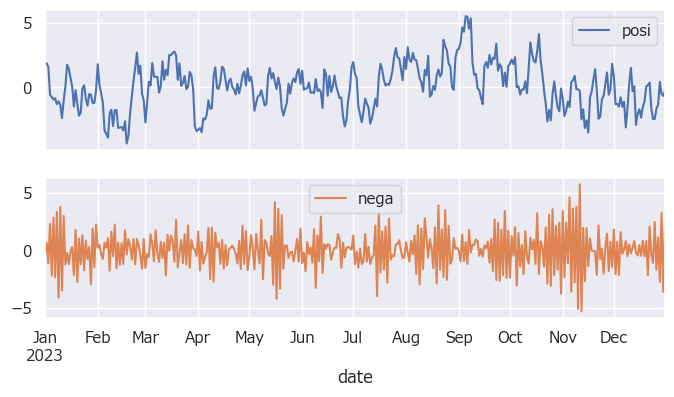

In [4]:
# 可視化
ar_data.plot(subplots=True)

#### AR過程に従うデータの自己相関

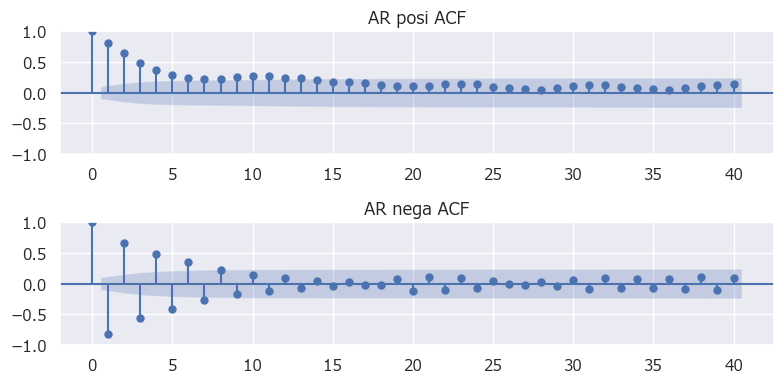

In [5]:
# グラフサイズの指定
fig, ax = plt.subplots(2, 1, figsize=(8, 4), tight_layout=True)

# コレログラムの作成
_ = sm.graphics.tsa.plot_acf(ar_data['posi'], lags=40, 
                             title='AR posi ACF', ax=ax[0])
_ = sm.graphics.tsa.plot_acf(ar_data['nega'], lags=40, 
                             title='AR nega ACF', ax=ax[1])

#### AR過程に従うデータの偏自己相関

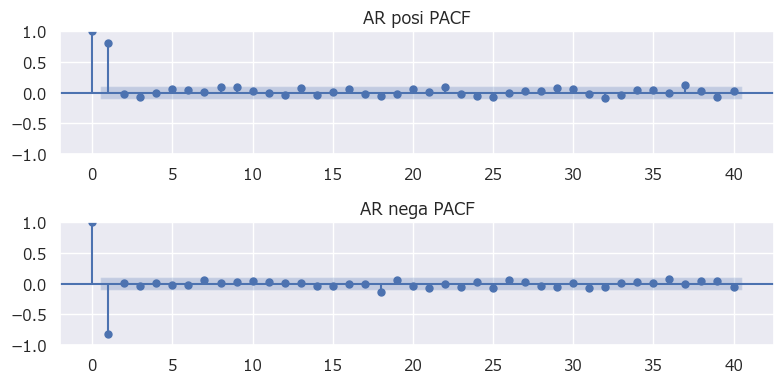

In [6]:
# グラフサイズの指定
fig, ax = plt.subplots(2, 1, figsize=(8, 4), tight_layout=True)

# コレログラムの作成
_ = sm.graphics.tsa.plot_pacf(ar_data['posi'], lags=40, 
                              title='AR posi PACF', ax=ax[0])
_ = sm.graphics.tsa.plot_pacf(ar_data['nega'], lags=40, 
                              title='AR nega PACF', ax=ax[1])

### MA過程

#### MA過程に従うデータの例

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>],
      dtype=object)

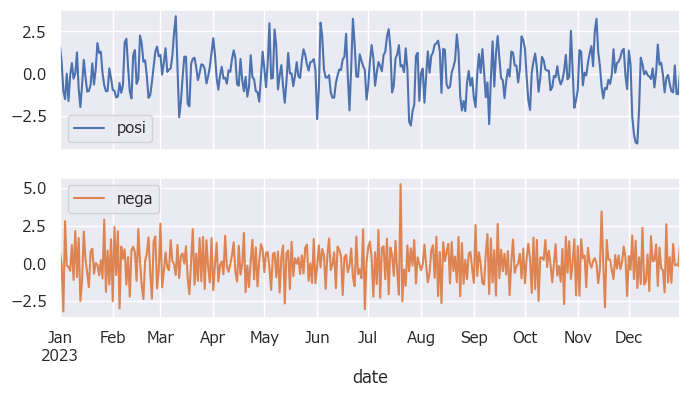

In [7]:
# データの読み込み
ma_data = pd.read_csv(
    '4-2-2-ma-data.csv', index_col='date', parse_dates=True, dtype='float')

# 1日単位のデータ
ma_data.index.freq = 'D'

# 可視化
ma_data.plot(subplots=True)

#### MA過程に従うデータの自己相関

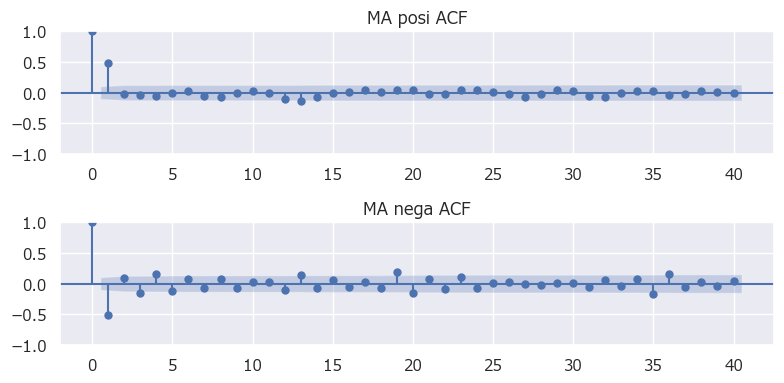

In [8]:
# グラフサイズの指定
fig, ax = plt.subplots(2, 1, figsize=(8, 4), tight_layout=True)

# コレログラムの作成
_ = sm.graphics.tsa.plot_acf(ma_data['posi'], lags=40, 
                             title='MA posi ACF', ax=ax[0])
_ = sm.graphics.tsa.plot_acf(ma_data['nega'], lags=40, 
                             title='MA nega ACF', ax=ax[1])

#### MA過程に従うデータの偏自己相関

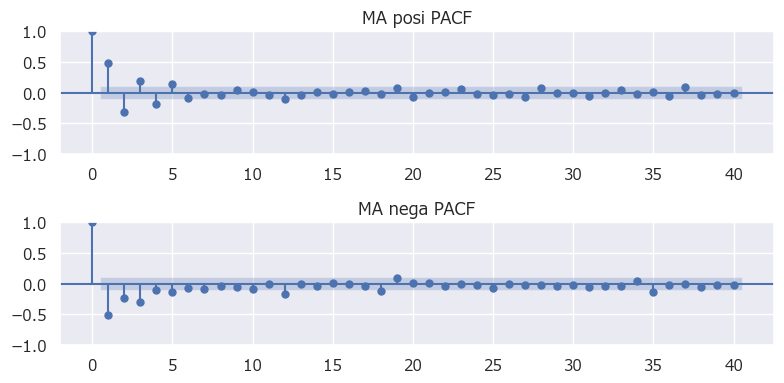

In [9]:
# グラフサイズの指定
fig, ax = plt.subplots(2, 1, figsize=(8, 4), tight_layout=True)

# コレログラムの作成
_ = sm.graphics.tsa.plot_pacf(ma_data['posi'], lags=40, 
                              title='MA posi PACF', ax=ax[0])
_ = sm.graphics.tsa.plot_pacf(ma_data['nega'], lags=40, 
                              title='MA nega PACF', ax=ax[1])

### 最小二乗法を用いたARモデルの推定

In [10]:
# 参考：分析の対象となるデータ
ar_data['posi'].head(3)

date
2023-01-01    1.788628
2023-01-02    1.867413
2023-01-03    1.590428
Freq: D, Name: posi, dtype: float64

#### 単回帰分析の利用

In [11]:
# ラグデータの作成
ar_lag = tsa.lagmat(
    ar_data['posi'], maxlag=1, original='in', use_pandas=True)

# 列名の変更
ar_lag.columns = ['target', 'lag1']

# 最初の1行を削除
ar_lag = ar_lag.iloc[1:, :]

# 結果の確認
print(ar_lag.head(3))

              target      lag1
date                          
2023-01-02  1.867413  1.788628
2023-01-03  1.590428  1.867413
2023-01-04 -0.591151  1.590428


In [12]:
# モデルの構築
ar_ols = smf.ols(formula='target ~ lag1', data=ar_lag).fit()

# 推定されたパラメータ
ar_ols.params

Intercept    0.001189
lag1         0.802707
dtype: float64

#### AutoRegの利用

In [13]:
# AutoRegを利用したモデル化
ar_autoreg = tsa.AutoReg(ar_data['posi'], lags=1).fit()

# 推定されたパラメータ
ar_autoreg.params

const      0.001189
posi.L1    0.802707
dtype: float64

#### sktimeの利用

In [14]:
# 予測機(線形回帰モデル)
regressor = LinearRegression()

# 再帰的に回帰分析を実行
forecaster = make_reduction(regressor, window_length=1, strategy="recursive")
forecaster.fit(ar_data['posi'])

# 推定されたパラメータ
forecaster.get_fitted_params()

{'estimator': LinearRegression(),
 'transformers': None,
 'window_length': 1,
 'estimator__coef': array([0.80270658]),
 'estimator__intercept': 0.0011885023794679685,
 'estimator__n_features_in': 1,
 'estimator__rank': 1,
 'estimator__singular': array([33.33510614])}

### 状態空間モデルを用いたARモデルの推定

In [15]:
# 状態空間モデルを利用したモデル化
mod_ar = tsa.SARIMAX(ar_data['posi'], order=(1, 0, 0), trend='c').fit()

# 推定されたパラメータ
mod_ar.params

intercept    0.009795
ar.L1        0.802726
sigma2       1.077611
dtype: float64

### 状態空間モデルを用いたMAモデルの推定

In [16]:
# 状態空間モデルを利用したモデル化
mod_ma = tsa.SARIMAX(ma_data['posi'], order=(0, 0, 1), trend='c').fit()

# 推定されたパラメータ
mod_ma.params

intercept    0.098855
ma.L1        0.775439
sigma2       0.910584
dtype: float64

### ARモデルによる予測

#### パラメータを使って予測値を計算する方法

In [17]:
# 推定されたパラメータ
ar_ols.params

Intercept    0.001189
lag1         0.802707
dtype: float64

In [18]:
# 1時点先の予測
ar_pred_1 = ar_ols.params.iloc[0] + \
            ar_ols.params.iloc[1] * ar_data['posi'].tail(1).values
print(ar_pred_1)

[-0.2189263]


In [19]:
# 2時点先以降の予測
ar_pred_2 = ar_ols.params.iloc[0] + ar_ols.params.iloc[1] * ar_pred_1
ar_pred_3 = ar_ols.params.iloc[0] + ar_ols.params.iloc[1] * ar_pred_2

print(ar_pred_2)
print(ar_pred_3)

[-0.17454508]
[-0.13891998]


#### statsmodelsにより推定されたモデルの予測

In [20]:
# AutoRegの結果を利用した予測
ar_autoreg.forecast(3)

2024-01-01   -0.218926
2024-01-02   -0.174545
2024-01-03   -0.138920
Freq: D, dtype: float64

#### sktimeにより推定されたモデルの予測

In [21]:
# sktimeによる予測
forecaster.predict(fh=np.arange(1, 4))

2024-01-01   -0.218926
2024-01-02   -0.174545
2024-01-03   -0.138920
Freq: D, Name: posi, dtype: float64

#### 長期予測

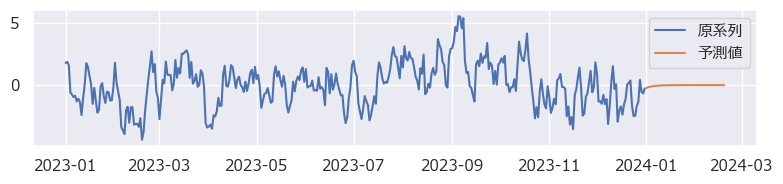

In [22]:
# グラフサイズの指定
fig, ax = plt.subplots(figsize=(8, 2), tight_layout=True)

# 原系列の折れ線グラフ
ax.plot(ar_data['posi'], label='原系列')

# 予測値の折れ線グラフ
ax.plot(ar_autoreg.forecast(50), label='予測値')

# 凡例
ax.legend()

### MAモデルによる予測

#### パラメータを使って予測値を計算する方法

In [23]:
# 推定されたパラメータ
mod_ma.params

intercept    0.098855
ma.L1        0.775439
sigma2       0.910584
dtype: float64

In [24]:
# 最終日の残差
ma_data['posi'].tail(1) - mod_ma.fittedvalues.tail(1)

date
2023-12-31   -0.229561
Freq: D, dtype: float64

In [25]:
# 最終日の残差
mod_ma.resid.tail(1)

date
2023-12-31   -0.229561
Freq: D, dtype: float64

In [26]:
# 翌日の予測値
mod_ma.params.iloc[0] + mod_ma.params.iloc[1] * mod_ma.resid.tail(1).values

array([-0.079155])

#### statsmodelsにより推定されたモデルの予測

In [27]:
mod_ma.forecast(3)

2024-01-01   -0.079155
2024-01-02    0.098855
2024-01-03    0.098855
Freq: D, Name: predicted_mean, dtype: float64

### ARIMA過程

#### ARIMA過程に従うデータの例

<Axes: xlabel='date'>

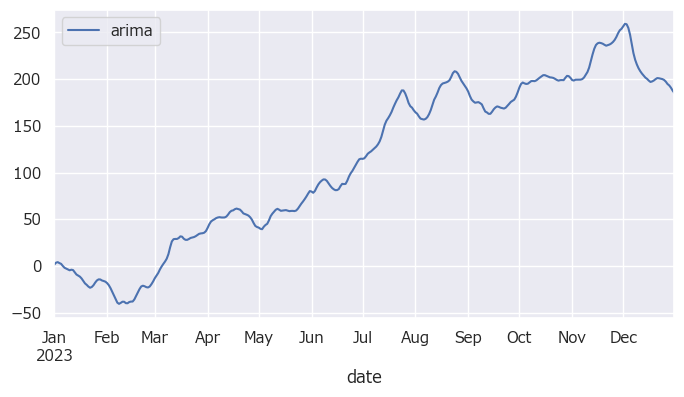

In [28]:
# データの読み込み
arima_data = pd.read_csv(
    '4-2-3-arima-data.csv', index_col='date', parse_dates=True, dtype='float')

# 1日単位のデータ
arima_data.index.freq = 'D'

# 可視化
arima_data.plot()

#### ARIMA過程に従うデータの自己相関・偏自己相関

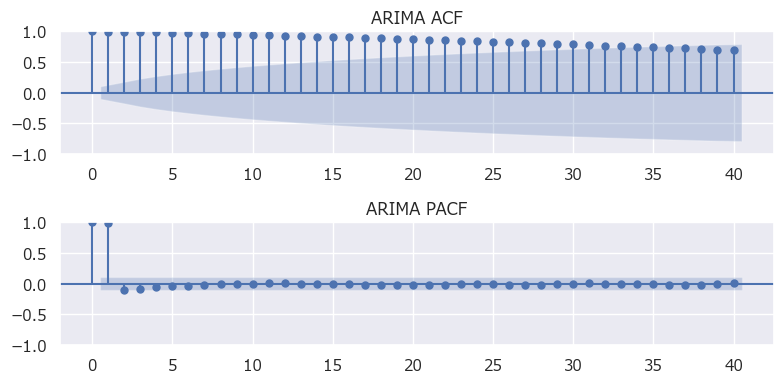

In [29]:
# グラフサイズの指定
fig, ax = plt.subplots(2, 1, figsize=(8, 4), tight_layout=True)

# コレログラムの作成
_ = sm.graphics.tsa.plot_acf(arima_data, lags=40, 
                             title='ARIMA ACF', ax=ax[0])
_ = sm.graphics.tsa.plot_pacf(arima_data, lags=40, 
                              title='ARIMA PACF', ax=ax[1])

#### 差分系列に対する自己相関・偏自己相関

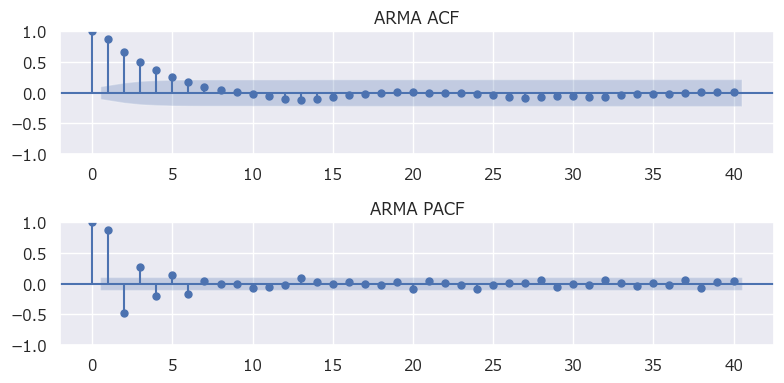

In [30]:
# 差分をとり、欠測値を排除する
arma_data = arima_data.diff().iloc[1:, :]

# グラフサイズの指定
fig, ax = plt.subplots(2, 1, figsize=(8, 4), tight_layout=True)

# コレログラムの作成
_ = sm.graphics.tsa.plot_acf(arma_data, lags=40, 
                             title='ARMA ACF', ax=ax[0])
_ = sm.graphics.tsa.plot_pacf(arma_data, lags=40, 
                              title='ARMA PACF', ax=ax[1])

### ARIMAモデルの推定と予測

#### ARIMAモデルの推定

In [31]:
# 状態空間モデルを利用したモデル化
mod_arima = tsa.SARIMAX(arima_data, order=(1, 1, 1), trend='c').fit()

# 推定されたパラメータ
mod_arima.params

intercept    0.110056
ar.L1        0.772905
ma.L1        0.788230
sigma2       0.905733
dtype: float64

#### ARIMAモデルによる予測

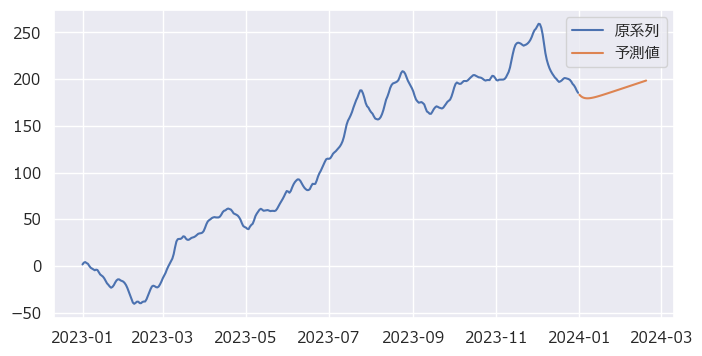

In [32]:
# グラフサイズの指定
fig, ax = plt.subplots(figsize=(8, 4))

# 原系列の折れ線グラフ
ax.plot(arima_data, label='原系列')

# 予測値の折れ線グラフ
ax.plot(mod_arima.forecast(50), label='予測値')

# 凡例
ax.legend()